In [1]:
from profiler.core import *

In [2]:
pf = Profiler(workers=2, verbose=False, tol=0, eps=0.01)

In [3]:
#pf.session.load_data(name='flights', src='file', fpath='/Users/zhihan/Documents/bart/data/clean_data/flights.csv', embedtxt=False)
pf.session.load_data(name='cancer', src='file', fpath='data/cancer.csv', embedtxt=False)


INFO:profiler.utility:[0.005952119827270508] Load Data start

INFO:profiler.dataset:inferred types of attributes: {
    "Smoker": "numeric",
    "Pollution": "numeric",
    "Cancer": "numeric",
    "Xray": "numeric",
    "Dyspnoea": "numeric"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'Smoker': ['equal'], 'Pollution': ['equal'], 'Cancer': ['equal'], 'Xray': ['equal'], 'Dyspnoea': ['equal']}
INFO:profiler.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utility:[0.027859926223754883] Load Data execution time: 0.021907806396484375



In [4]:
pf.session.load_training_data()

INFO:profiler.utility:[0.0338139533996582] Create Training Data start

INFO:profiler.transformer:needs multiplier = 21 to bound the error in inv cov estimation <= 0.01000000
INFO:profiler.transformer:use multiplier = 21, and the bound is 0.00001717
INFO:profiler.transformer:Draw Pairs
100%|██████████| 5/5 [00:00<00:00, 64.86it/s]
INFO:profiler.transformer:Number of training samples: 250000
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[0.25797295570373535] Create Training Data execution time: 0.22415900230407715



In [5]:
cov = pf.session.struct_engine.estimate_covariance()

In [6]:
from profiler.utility import visualize_heatmap
visualize_heatmap(cov)

<Figure size 1000x800 with 2 Axes>

INFO:profiler.learner:use threshold 0.0138


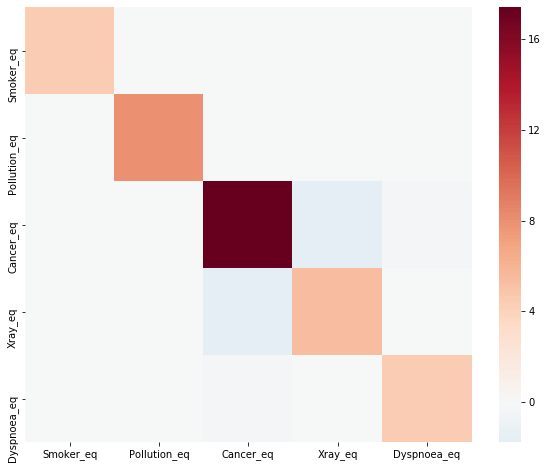

In [37]:
pf.session.struct_engine.param['sparsity'] = 0
pf.session.struct_engine.param['take_neg'] = True
pf.session.struct_engine.param['take_abs'] = False
inv_cov, est_cov = pf.session.struct_engine.estimate_inverse_covariance(cov.values)

Xray_eq,Dyspnoea_eq -> Cancer_eq
Cancer_eq -> Xray_eq
Cancer_eq -> Dyspnoea_eq


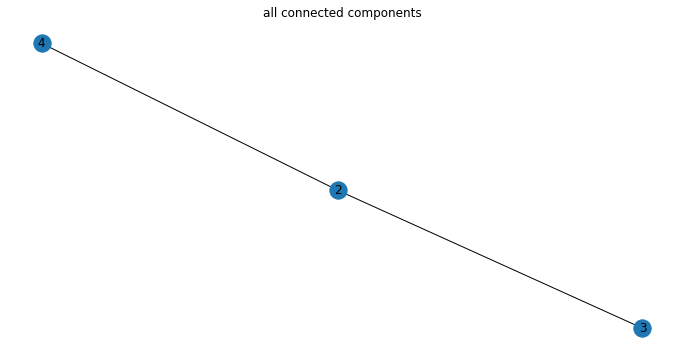

In [38]:
G = pf.session.struct_engine.recover_moral_graphs(inv_cov)
Gs = G.get_undirected_connected_components()

In [39]:
components = [list(g.idx_to_name.keys()) for g in Gs]

In [40]:
components[0]

[2, 3, 4]

In [41]:
from profiler.learner import StructureLearner
from sksparse.cholmod import cholesky, analyze
from itertools import permutations 
from scipy import sparse
from tqdm import tqdm
import pandas as pd

for c in components:
    U_hat = None
    # cholesky decomposition of invcov
    A = sparse.csr_matrix(inv_cov.values)
    factor = analyze(A)
    perm = factor.P()
    mat = inv_cov.iloc[perm, perm]
    A = sparse.csr_matrix(mat.values)
    factor = cholesky(A)
    U = factor.L_D()[0].toarray()
    U_hat = StructureLearner.get_df(U, inv_cov.columns.values[perm])    
    break

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/ipykernel_launcher.py:12: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  if sys.path[0] == '':
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/ipykernel_launcher.py:16: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  app.launch_new_instance()


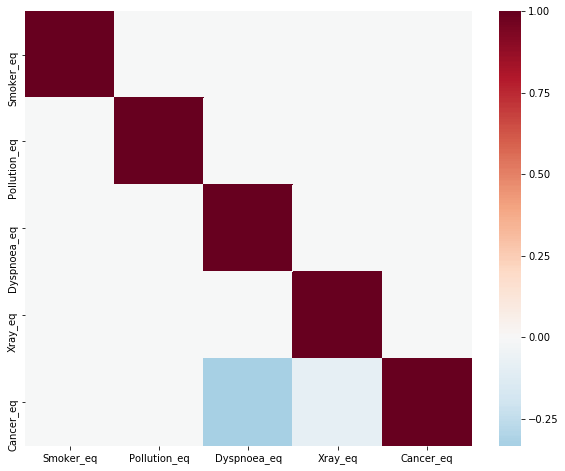

In [42]:
visualize_heatmap(U_hat)

In [43]:
samples = pf.session.training_data.reset_index()
def validate_relation(left, right, data):
    stat = data.groupby(list(left)+[right])['index'].count()
    idx = list([1.0]*len(left))
    agree = stat.loc[tuple(idx + [1.0])] 
    disagree = stat.loc[tuple(idx + [0.0])] 
    ratio = agree / float(agree+disagree)
    return ratio, stat

In [44]:
for i, attr in enumerate(U_hat):
    columns = U_hat.columns.values[0:i]
    parents = columns[U_hat.iloc[i, 0:i] != 0]
    if len(parents) > 0:
        support, stat = validate_relation(parents, attr, samples)
        print("{} -> {} ({})".format(",".join(parents), attr, support))

Dyspnoea_eq,Xray_eq -> Cancer_eq (0.9706606980298488)
